# Understanding the knickpoints in the Rapel landscape and the erosion rate distributions therein

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from TopoAnalysis import dem as d
from scipy.stats import linregress
from scipy.signal import savgol_filter
from rasterio.mask import mask as rasterio_mask
from rasterio.features import geometry_mask as rasterio_geom_mask

In [10]:
# Caluclate the chi elevation and plot to find the elvation 
# d.Chi(flow_direction = fd, area = area, theta = <theta>, Ao = <Ao> (not particularly sensitive to that value), outlets = list of (x,y) coordinates of outlets)
# chi vs elevation plot

outlets = [
    (246249.2076, 6240448.447),
    (250212.9354, 6237948.848),
    (250603.5211, 6228481.157),
    (262281.9748, 6217862.614)
]

samples = [
    ('RP-S2'),
    ('RP-S3'),
    ('RP-S3u'),
    ('RP-S4u')
]

In [4]:
area = d.Area.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_area_utm30m')
print('area loaded')
fd = d.FlowDirectionD8.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_fd_utm30m')
print('fd loaded')
elevation = d.Elevation.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif')
print('elevation loaded')

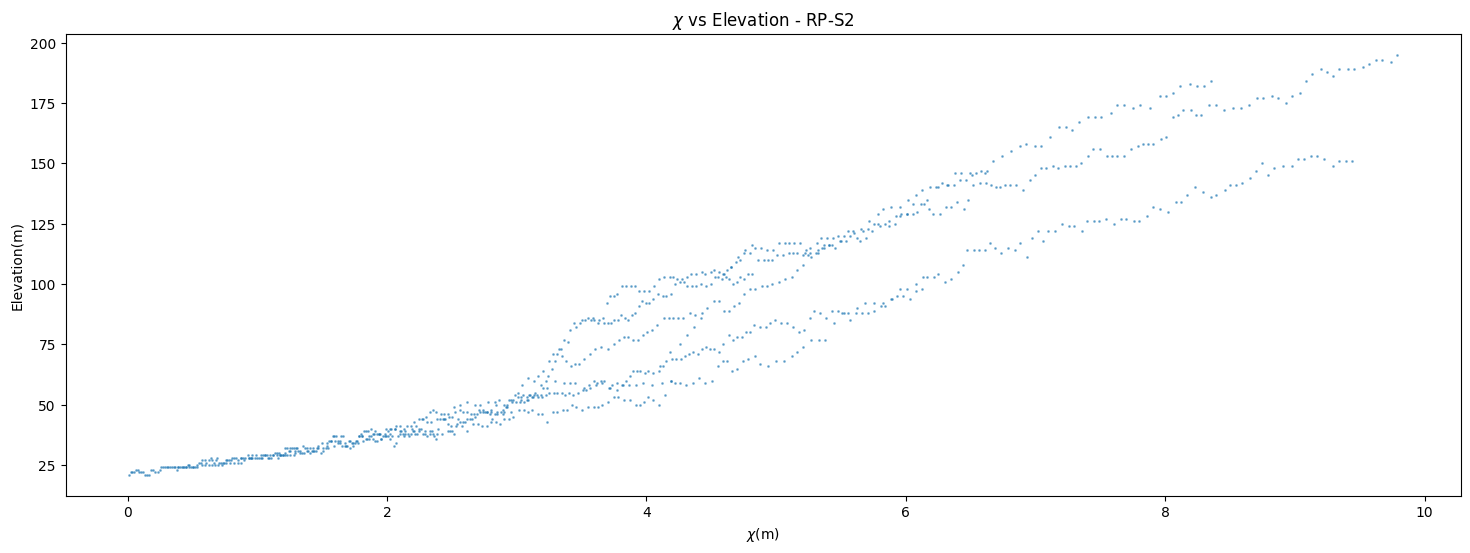

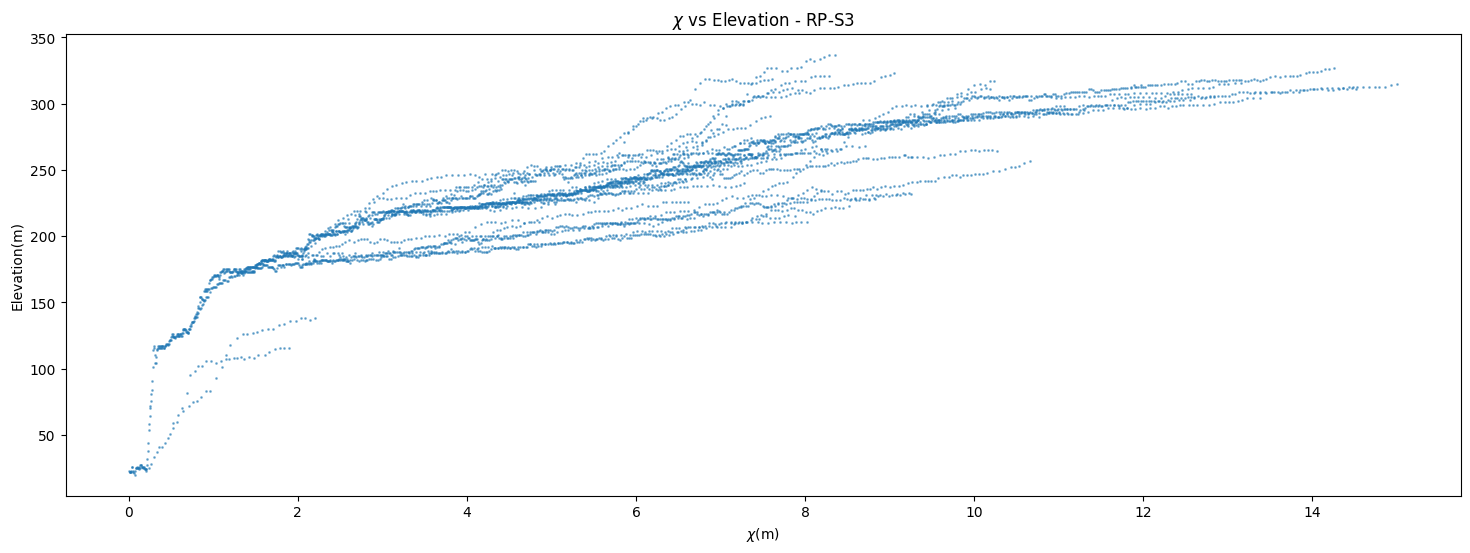

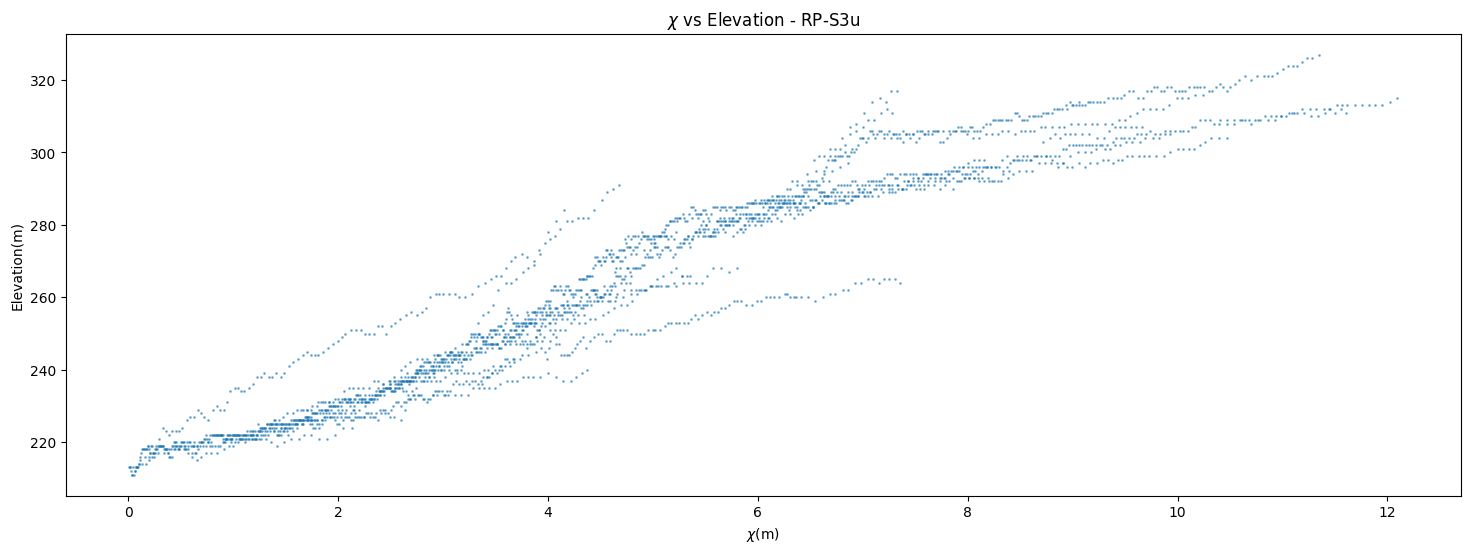

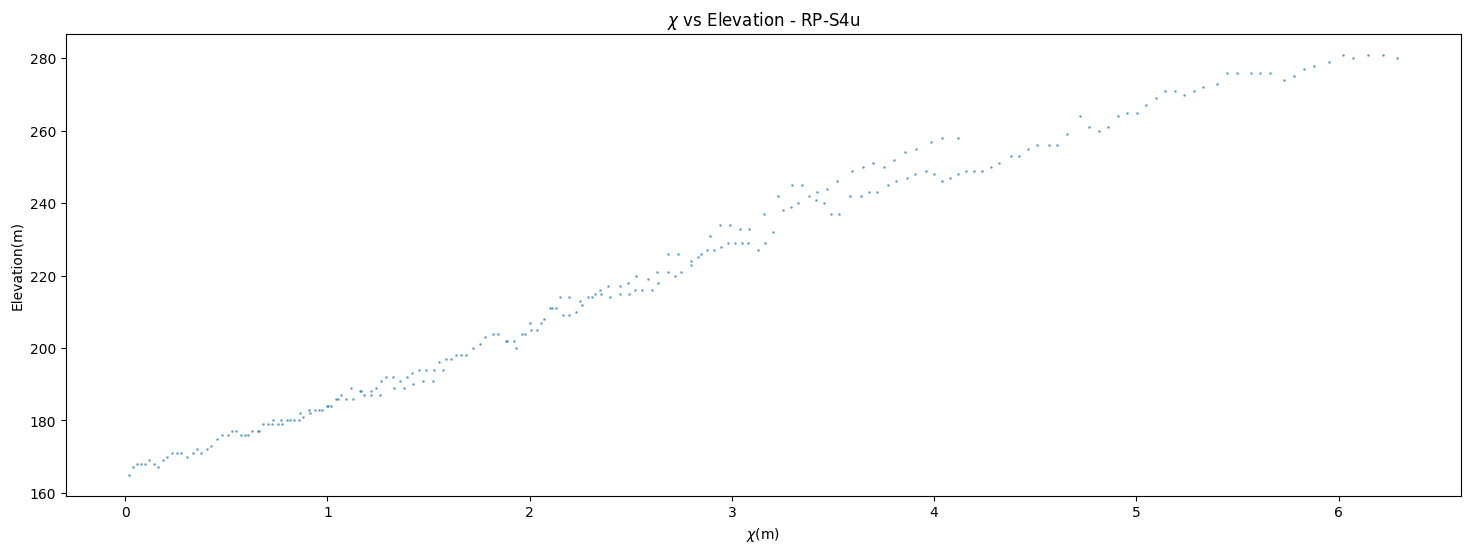

In [12]:
for i, (outlet, sample) in enumerate(zip(outlets, samples)):
    chi_single = d.Chi(flow_direction=fd, area=area, theta=0.45, Ao=1, outlets=[outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6  # 1 km^2 in m^2
    
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_data[mask_out], elev_data[mask_out], s=1, alpha=0.5)
    plt.xlabel('$\\chi$(m)')
    plt.ylabel('Elevation(m)')
    plt.title(f'$\\chi$ vs Elevation - {sample}')
    #plt.savefig(f'Figures/chi_elevation_plot_{sample}.png', bbox_inches='tight', pad_inches=0.1)  # Unique filename for each
    plt.show()


RP-S2:
  Chi: 8.75, Elevation: 99


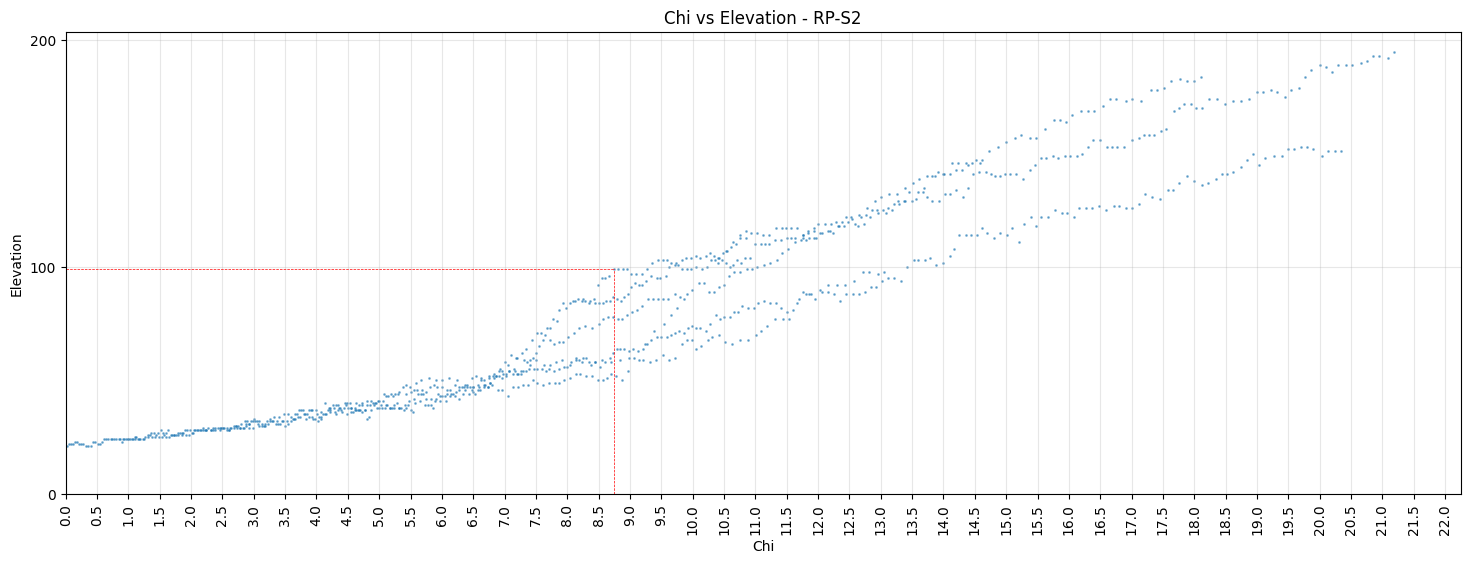


RP-S3:
  Chi: 0.78, Elevation: 117
  Chi: 2.90, Elevation: 175
  Chi: 8.50, Elevation: 245


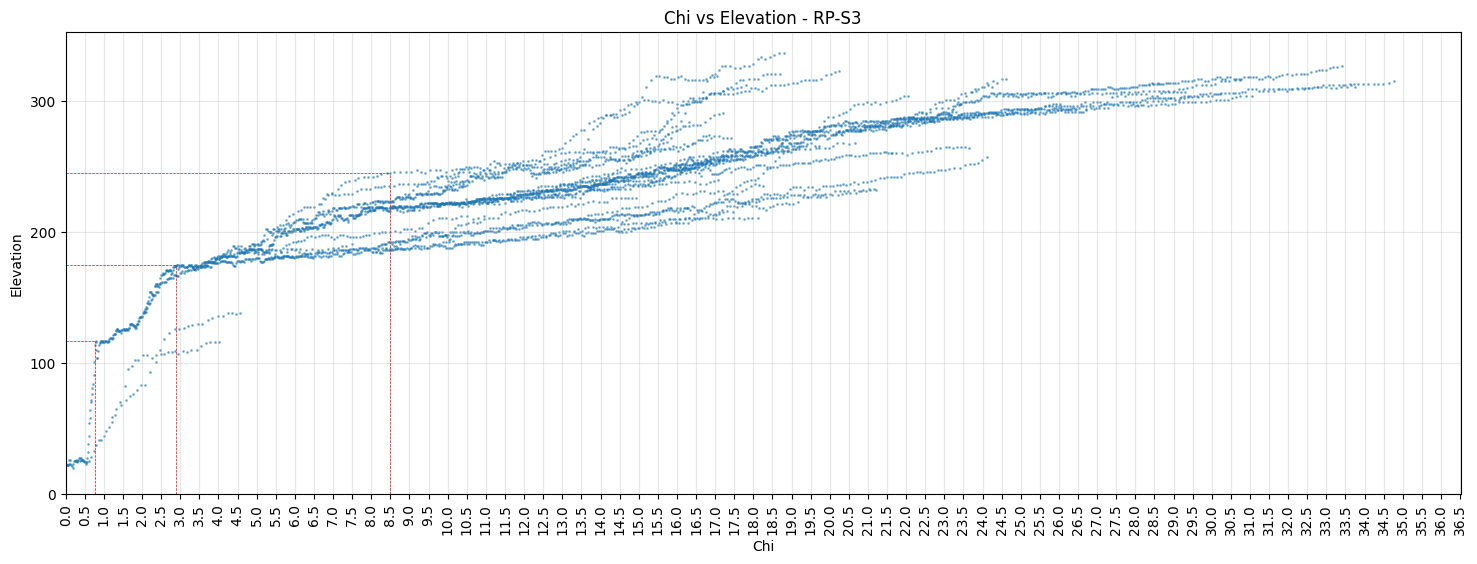

In [14]:
outlet_names = ['RP-S2', 'RP-S3']
outlets = [(246249.2076, 6240448.447),
           (250212.9354, 6237948.848)  # Use only these outlets
          ]
           
for i, outlet in enumerate(outlets):
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6
    chi_masked = chi_data[mask_out]
    elev_masked = elev_data[mask_out]
    
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_masked, elev_masked, s=1, alpha=0.5)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.5))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
    
    plt.grid(True, alpha=0.3, which='major')
    plt.gca().tick_params(axis='x', rotation=90)
    
    # Knickpoint dictionary
    knickpoints_dict = {
        'RP-S2': [8.75],
        'RP-S3': [0.78, 2.9, 8.5],
    }
    
    outlet_name = outlet_names[i]
    knickpoints = knickpoints_dict.get(outlet_name, [])
    
    print(f"\n{outlet_name}:")
    for chi_val in knickpoints:
        idx = np.argmin(np.abs(chi_masked - chi_val))
        elev_val = elev_masked[idx]
        
        print(f"  Chi: {chi_val:.2f}, Elevation: {elev_val:.0f}")
        
        # Lines only to intersection point
        plt.plot([chi_val, chi_val], [0, elev_val], 'r--', linewidth=0.5)
        plt.plot([0, chi_val], [elev_val, elev_val], 'r--', linewidth=0.5)
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    plt.title(f'Chi vs Elevation - {outlet_name}')
    plt.show()


RP_S3 - Monte Carlo Analysis (10,000 simulations)

Knickpoint elevation: 117m
----------------------------------------------------------------------
  Area above 117m: 208.87 km²
  Area below 117m: 0.96 km²
  Total area: 209.83 km²

  Input erosion rates:
    Upper: 30 ± 0.572 m/Myr
    Lower (measured): 34 ± 0.642 m/Myr

  Monte Carlo Results for Canyon (below knickpoint):
    Mean: 901.21 m/Myr
    Std Dev: 187.18 m/Myr
    1σ Range (68%): 712.88 to 1085.35 m/Myr (±186.24)
    2σ Range (95%): 529.84 to 1272.80 m/Myr (±371.48)
    Relative uncertainty: 20.8%
    Weighted average: 34.00 m/Myr

Knickpoint elevation: 175m
----------------------------------------------------------------------
  Area above 175m: 203.42 km²
  Area below 175m: 6.41 km²
  Total area: 209.83 km²

  Input erosion rates:
    Upper: 30 ± 0.572 m/Myr
    Lower (measured): 34 ± 0.642 m/Myr

  Monte Carlo Results for Canyon (below knickpoint):
    Mean: 161.06 m/Myr
    Std Dev: 27.99 m/Myr
    1σ Range (68%): 133.

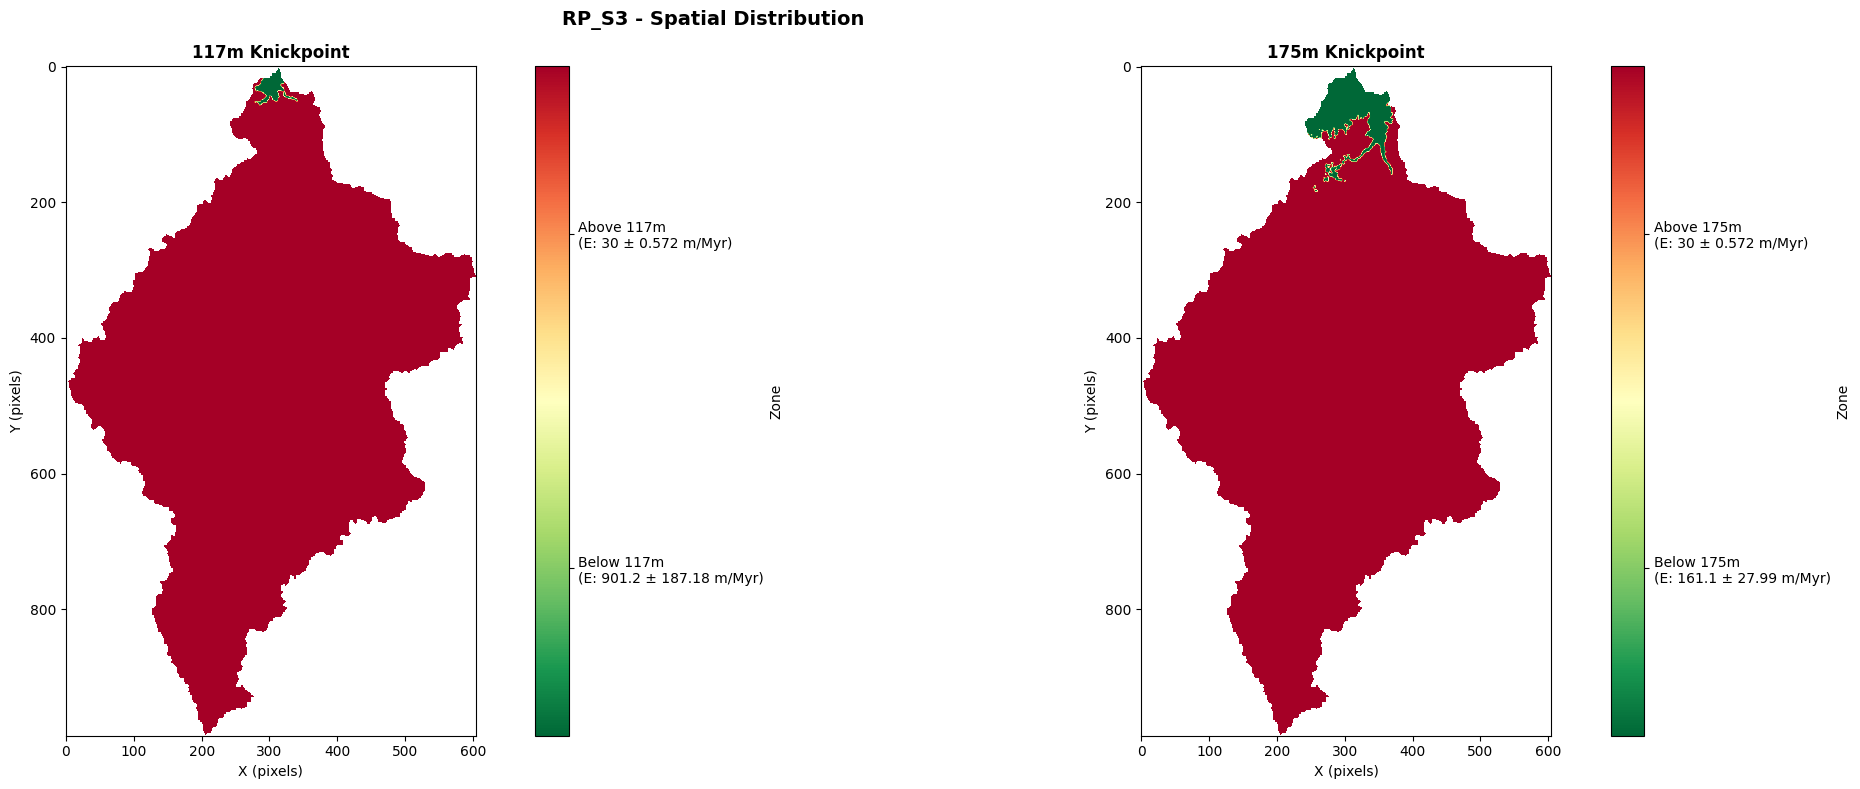

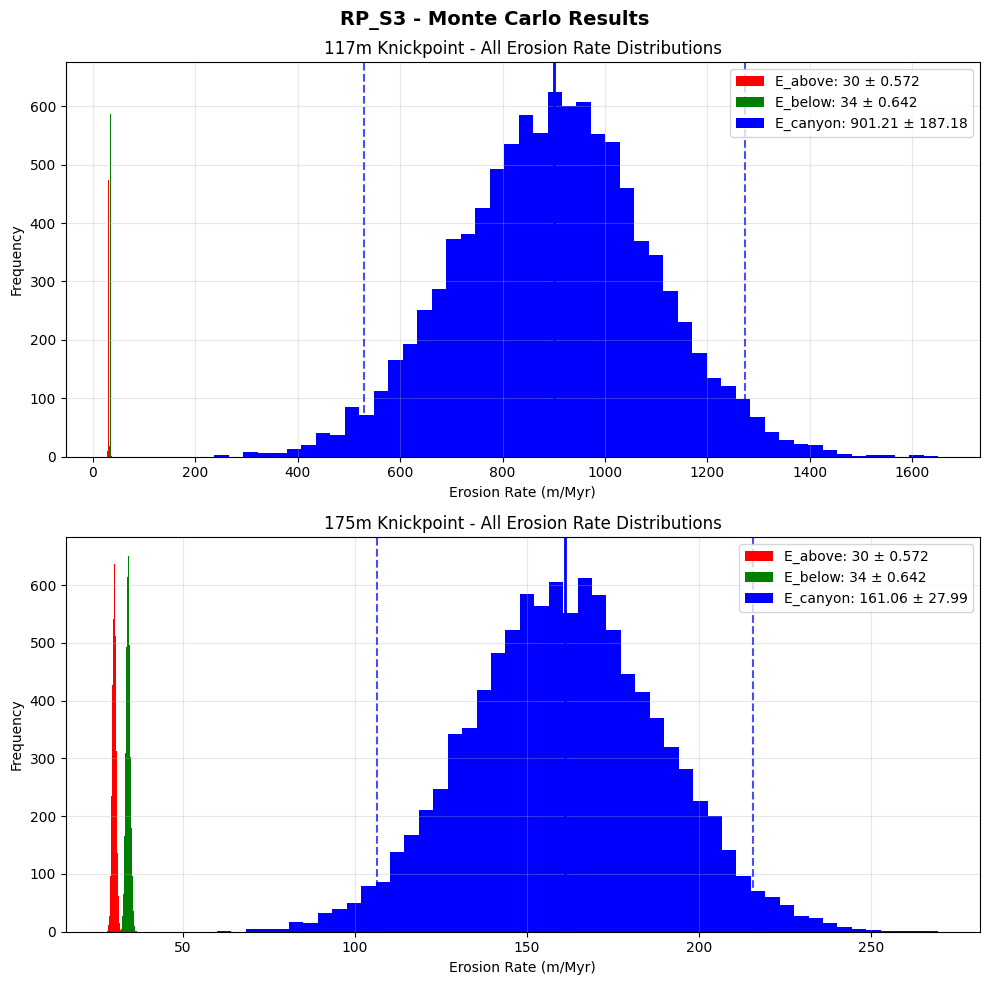

In [26]:
# Erosion rate analysis of canyon area below different knickpoint locations

# set random seed
np.random.seed(17) # random seed set to arbitrary number

def analyze_erosion_monte_carlo(dem_file, polygon_file, watershed_name, erosion_above=30, erosion_below=34, 
                                erosion_above_err=0.572, erosion_below_err=0.642, knickpoint_elevations=[117, 175],
                                num_simulations=10000):
    """
    Analyze area-weighted erosion rates using Monte Carlo simulation.
    
    Parameters:
    - dem_file: path to DEM raster file
    - polygon_file: path to watershed polygon shapefile
    - watershed_name: name for the watershed
    - erosion_above: erosion rate above knickpoint (m/Myr)
    - erosion_below: erosion rate below knickpoint (m/Myr)
    - erosion_above_err: uncertainty in erosion_above (1-sigma)
    - erosion_below_err: uncertainty in erosion_below (1-sigma)
    - knickpoint_elevations: list of elevation thresholds to analyze
    - num_simulations: number of Monte Carlo simulations (default 10000)
    """
    
    # Load polygon
    polygon = gpd.read_file(polygon_file)
    shapes = [geom for geom in polygon.geometry]
    
    # Load and mask DEM
    with rasterio.open(dem_file) as src:
        dem_data, dem_transform = mask(src, shapes, crop=True)
        dem_data = dem_data[0].astype(float)
    
    # Set pixels outside polygon to NaN
    geom_mask = geometry_mask(shapes, out_shape=dem_data.shape, transform=dem_transform, invert=True)
    dem_data[~geom_mask] = np.nan
    
    # Get cell size
    cell_size = dem_transform[0]
    cell_area = cell_size ** 2
    
    print(f"\n{'='*70}")
    print(f"{watershed_name} - Monte Carlo Analysis ({num_simulations:,} simulations)")
    print(f"{'='*70}")
    
    # Create figure for spatial plots
    fig_spatial, axes_spatial = plt.subplots(1, len(knickpoint_elevations), 
                                              figsize=(12 * len(knickpoint_elevations), 8))
    if len(knickpoint_elevations) == 1:
        axes_spatial = [axes_spatial]
    
    # Create figure for histograms
    fig_hist, axes_hist = plt.subplots(len(knickpoint_elevations), 1, 
                                        figsize=(10, 5 * len(knickpoint_elevations)))
    if len(knickpoint_elevations) == 1:
        axes_hist = [axes_hist]
    
    for idx, knickpoint_elevation in enumerate(knickpoint_elevations):
        ax_spatial = axes_spatial[idx]
        ax_hist = axes_hist[idx]
        
        # Create masks
        valid_mask = ~np.isnan(dem_data)
        above_mask = (dem_data > knickpoint_elevation) & valid_mask
        below_mask = (dem_data <= knickpoint_elevation) & valid_mask
        
        # Calculate areas (treated as exact)
        area_above = np.sum(above_mask) * cell_area
        area_below = np.sum(below_mask) * cell_area
        total_area = area_above + area_below
        
        if area_below == 0:
            print(f"\nKnickpoint elevation: {knickpoint_elevation}m - SKIPPED (no area below knickpoint)")
            continue
        
        # Monte Carlo simulation
        # Generate random samples for erosion rates
        erosion_above_samples = np.random.normal(erosion_above, erosion_above_err, num_simulations)
        erosion_below_samples = np.random.normal(erosion_below, erosion_below_err, num_simulations)
        
        # Calculate E_lower for each simulation
        erosion_lower_samples = (erosion_below_samples * total_area - erosion_above_samples * area_above) / area_below
        
        # Calculate statistics from Monte Carlo samples
        erosion_lower_mean = np.mean(erosion_lower_samples)
        erosion_lower_median = np.median(erosion_lower_samples)
        erosion_lower_std = np.std(erosion_lower_samples)
        
        # Calculate confidence intervals
        p2_5 = np.percentile(erosion_lower_samples, 2.5)    # Lower 2σ
        p16 = np.percentile(erosion_lower_samples, 16)      # Lower 1σ
        p84 = np.percentile(erosion_lower_samples, 84)      # Upper 1σ
        p97_5 = np.percentile(erosion_lower_samples, 97.5)  # Upper 2σ
        
        # Calculate weighted average
        weighted_erosion = (np.mean(erosion_above_samples) * area_above + erosion_lower_mean * area_below) / total_area
        
        # Calculate relative uncertainty
        rel_uncertainty = (erosion_lower_std / erosion_lower_mean) * 100 if erosion_lower_mean != 0 else 0
        
        # Create spatial visualization
        colored_dem = np.full_like(dem_data, np.nan, dtype=float)
        colored_dem[above_mask] = 1
        colored_dem[below_mask] = 0
        
        im = ax_spatial.imshow(colored_dem, cmap='RdYlGn_r', vmin=0, vmax=1)
        cbar = plt.colorbar(im, ax=ax_spatial, label='Zone')
        cbar.set_ticks([0.25, 0.75])
        cbar.set_ticklabels([f'Below {knickpoint_elevation}m\n(E: {erosion_lower_mean:.1f} ± {erosion_lower_std:.2f} m/Myr)', 
                              f'Above {knickpoint_elevation}m\n(E: {erosion_above} ± {erosion_above_err} m/Myr)'])
        
        ax_spatial.set_title(f'{knickpoint_elevation}m Knickpoint', fontsize=12, fontweight='bold')
        ax_spatial.set_xlabel('X (pixels)')
        ax_spatial.set_ylabel('Y (pixels)')
        
        # Create combined histogram showing all three distributions
        ax_hist.hist(erosion_above_samples, bins=50, alpha=1, color='red', label=f'E_above: {erosion_above} ± {erosion_above_err}')
        ax_hist.hist(erosion_below_samples, bins=50, alpha=1, color='green', label=f'E_below: {erosion_below} ± {erosion_below_err}')
        ax_hist.hist(erosion_lower_samples, bins=50, alpha=1, color='blue', label=f'E_canyon: {erosion_lower_mean:.2f} ± {erosion_lower_std:.2f}')
        
        # Add vertical lines for E_canyon confidence intervals
        ax_hist.axvline(erosion_lower_mean, color='blue', linestyle='-', linewidth=2)
        ax_hist.axvline(p2_5, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
        ax_hist.axvline(p97_5, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
        
        ax_hist.set_xlabel('Erosion Rate (m/Myr)')
        ax_hist.set_ylabel('Frequency')
        ax_hist.set_title(f'{knickpoint_elevation}m Knickpoint - All Erosion Rate Distributions')
        ax_hist.legend(loc='upper right')
        ax_hist.grid(True, alpha=0.3)
        
        # Print results
        print(f"\nKnickpoint elevation: {knickpoint_elevation}m")
        print("-" * 70)
        print(f"  Area above {knickpoint_elevation}m: {area_above/1e6:,.2f} km²")
        print(f"  Area below {knickpoint_elevation}m: {area_below/1e6:,.2f} km²")
        print(f"  Total area: {total_area/1e6:,.2f} km²")
        
        print(f"\n  Input erosion rates:")
        print(f"    Upper: {erosion_above} ± {erosion_above_err} m/Myr")
        print(f"    Lower (measured): {erosion_below} ± {erosion_below_err} m/Myr")
        print(f"\n  Monte Carlo Results for Canyon (below knickpoint):")
        print(f"    Mean: {erosion_lower_mean:.2f} m/Myr")
        print(f"    Std Dev: {erosion_lower_std:.2f} m/Myr")
        print(f"    1σ Range (68%): {p16:.2f} to {p84:.2f} m/Myr (±{(p84-p16)/2:.2f})")
        print(f"    2σ Range (95%): {p2_5:.2f} to {p97_5:.2f} m/Myr (±{(p97_5-p2_5)/2:.2f})")
        print(f"    Relative uncertainty: {rel_uncertainty:.1f}%")
        print(f"    Weighted average: {weighted_erosion:.2f} m/Myr")
    
    fig_spatial.suptitle(f'{watershed_name} - Spatial Distribution', fontsize=14, fontweight='bold')
    fig_spatial.tight_layout()
    fig_spatial.savefig(f'/Users/Glong1/Desktop/erosion_analysis_{watershed_name}_spatial.png', dpi=150, bbox_inches='tight')
    
    fig_hist.suptitle(f'{watershed_name} - Monte Carlo Results', fontsize=14, fontweight='bold')
    fig_hist.tight_layout()
    #fig_hist.savefig(f'/Users/Glong1/Desktop/erosion_analysis_{watershed_name}_histogram.png', dpi=150, bbox_inches='tight')
    
    plt.show()

# Use the function
dem_file = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
watersheds = [
    ('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp', 'RP_S3'),
]

for polygon_file, name in watersheds:
    analyze_erosion_monte_carlo(dem_file, polygon_file, name, 
                                erosion_above=30, erosion_below=34, 
                                erosion_above_err=0.572, erosion_below_err=0.642, 
                                knickpoint_elevations=[117, 175],
                                num_simulations=10000)

In [8]:
import pandas as pd

outlets = [
    (246249.2076, 6240448.447),
    (250212.9354, 6237948.848),
    (250603.5211, 6228481.157),
    (262281.9748, 6217862.614),
    (264603.93, 6224733.92)
]

def export_outlet_data(outlet_index, filename=None):
    """
    Export chi and elevation data for an outlet to CSV.
    
    outlet_index: which outlet to export (0-4)
    filename: name of CSV file (default: outlet_0.csv, outlet_1.csv, etc.)
    """
    if filename is None:
        filename = f'outlet_{outlet_index}.csv'
    
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Create dataframe and save
    df = pd.DataFrame({
        'Chi': chi_filtered,
        'Elevation': elev_filtered
    })
    
    df.to_csv(filename, index=False)
    print(f"Saved {filename} with {len(df)} data points")
    return df

# export files
for i in range(4):
    export_outlet_data(i, f'/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_{i}.csv')

Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_0.csv with 980 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_1.csv with 4986 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_2.csv with 2521 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_3.csv with 233 data points


# ksn (steepness) idenification through linear regression of chi-elevation plots

In [27]:
def analyze_outlet(outlet_index, knickpoints):
    """
    Calculate and plot ksn for different segments of a single outlet.
    
    outlet_index: which outlet to analyze (0-4)
    knickpoints: list of (chi, elevation) tuples marking segment boundaries
    """
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Plot all data
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_filtered, elev_filtered, s=1, alpha=0.5, label='Data', color='gray')
    
    # Plot knickpoints
    knickpoint_chis = [k[0] for k in knickpoints]
    knickpoint_elevs = [k[1] for k in knickpoints]
    plt.scatter(knickpoint_chis, knickpoint_elevs, color='black', s=100, marker='.', linewidth=1, label='Knickpoints')
    
    ksn_list = []
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Create segments from knickpoints
    for seg_idx in range(len(knickpoints) - 1):
        chi_min = knickpoints[seg_idx][0]
        chi_max = knickpoints[seg_idx + 1][0]
        
        segment_mask = (chi_filtered >= chi_min) & (chi_filtered <= chi_max)
        chi_seg = chi_filtered[segment_mask]
        elev_seg = elev_filtered[segment_mask]
        
        if len(chi_seg) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(chi_seg, elev_seg)
            ksn_list.append(slope)
            
            # Plot the fitted line for this segment
            x_line = np.array([chi_seg.min(), chi_seg.max()])
            y_line = slope * x_line + intercept
            plt.plot(x_line, y_line, linewidth=2.5, color=colors[seg_idx], 
                    label=f'Segment {seg_idx+1}: ksn = {slope:.2f} (R² = {r_value**2:.3f})')
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    plt.title(f'Chi vs Elevation - Outlet {outlet_index}')
    plt.legend()
    plt.show()
    
    print(f"Outlet {outlet_index}: ksn values = {[f'{k:.2f}' for k in ksn_list]}")
    return ksn_list

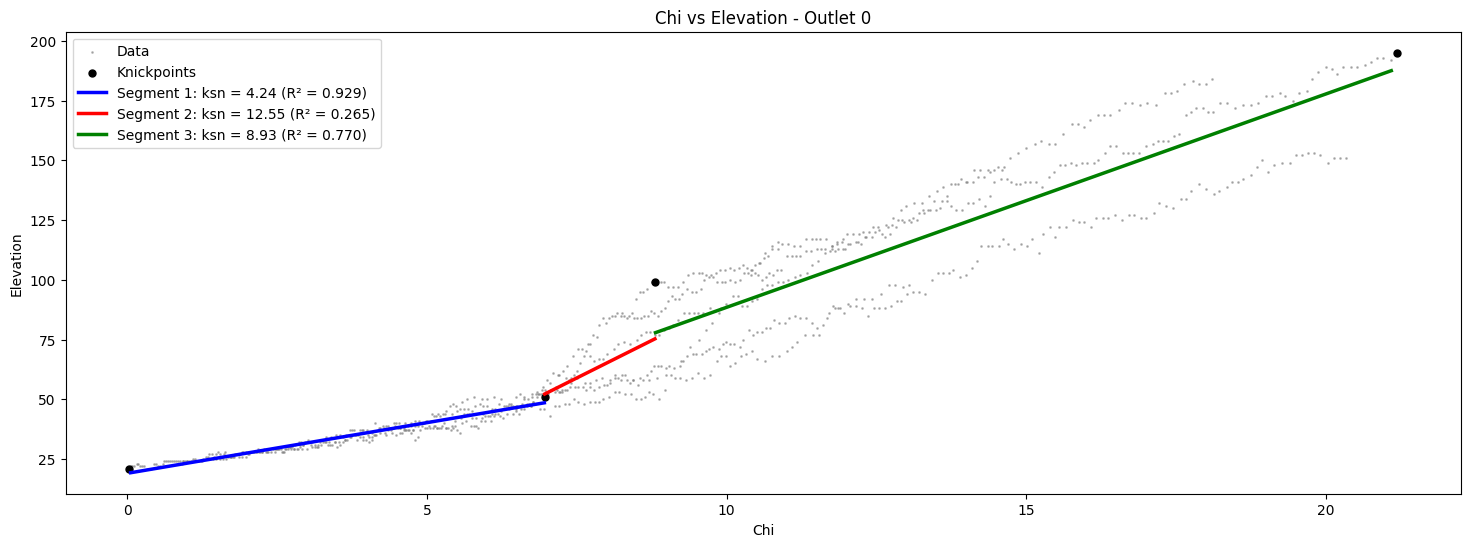

Outlet 0: ksn values = ['4.24', '12.55', '8.93']


[4.23736959189485, 12.547448575438978, 8.92704741013345]

In [10]:
# Enter knickpoint (chi, elevation) locations both the bottom and top locations:
# RP-S2
analyze_outlet(0, [(0.026572082, 21), (6.96, 51), (8.81, 99), (21.1904427, 195)])

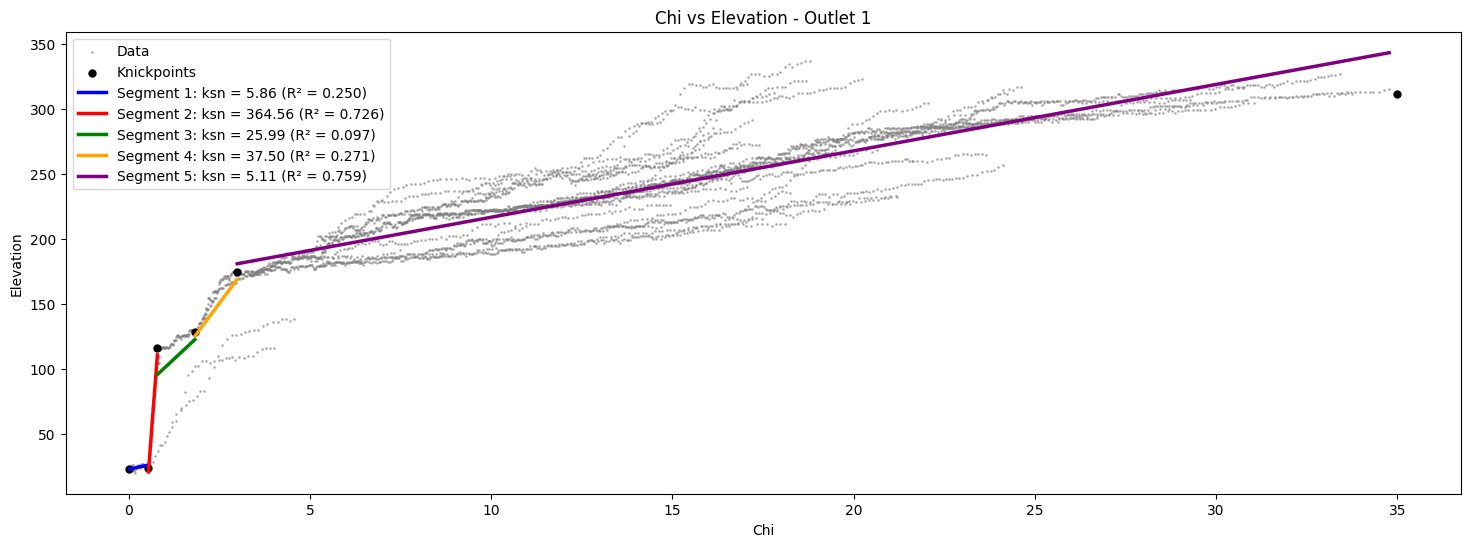

Outlet 1: ksn values = ['5.86', '364.56', '25.99', '37.50', '5.11']


[5.864638619390934,
 364.5647448323169,
 25.98714700138822,
 37.49838582403038,
 5.107038106606756]

In [30]:
# RP-S3
analyze_outlet(1, [(0.012829789, 23), (0.547, 24), (0.796, 116), (1.84, 128), (2.997, 174), (35, 311)])

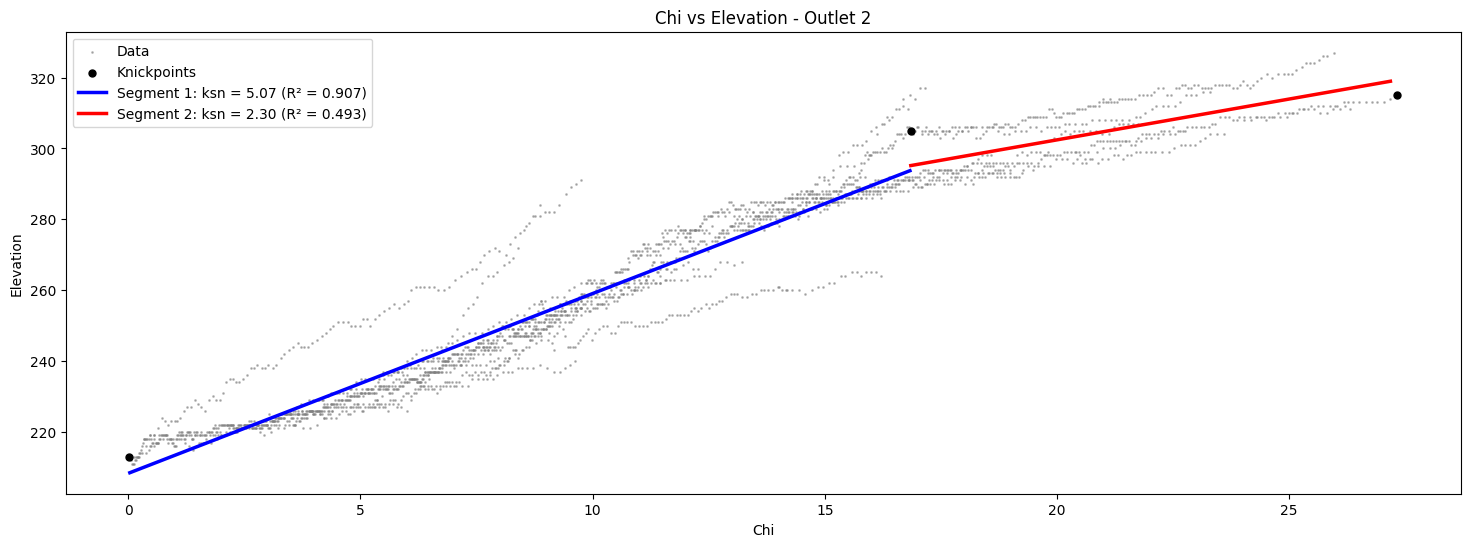

Outlet 2: ksn values = ['5.07', '2.30']


[5.072765847210626, 2.303693760438962]

In [12]:
# RP-S3u
analyze_outlet(2, [(0.016482489, 213), (16.85, 305), (27.32708722,315)])

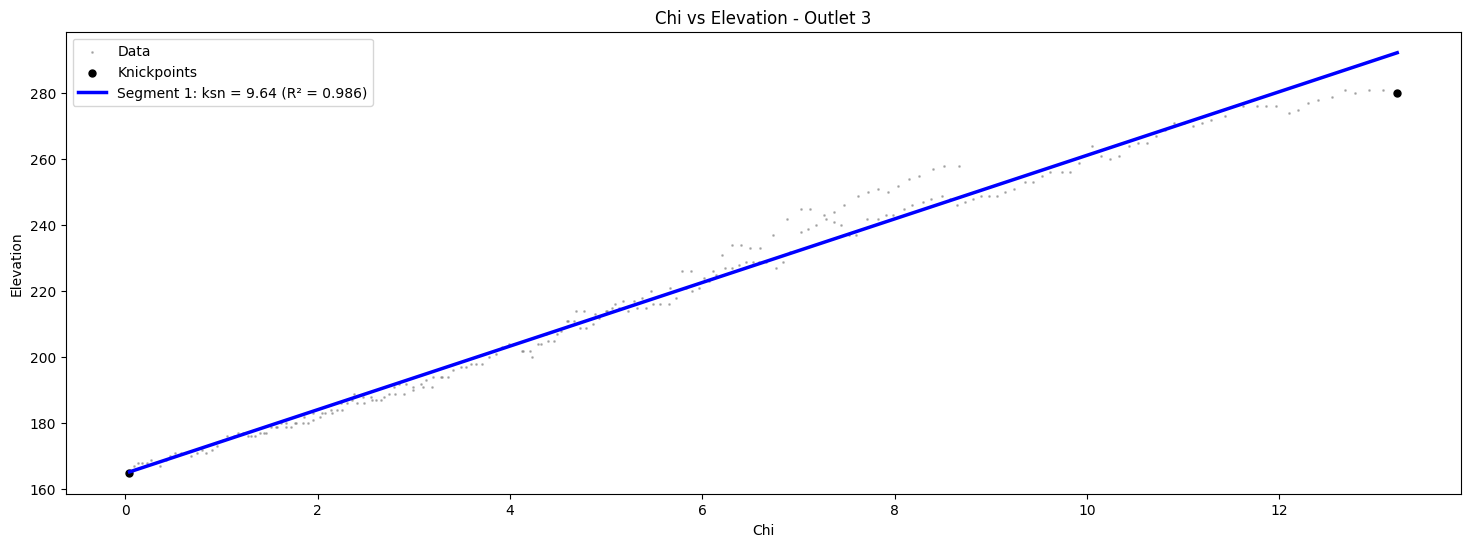

Outlet 3: ksn values = ['9.64']


[9.635589051335689]

In [13]:
# RP-S4u
analyze_outlet(3, [(0.04, 165), (13.23, 280)])

In [14]:
# Getting ksn from slope of smoothed lines. 

def analyze_outlet_smoothed(outlet_index, knickpoints, smooth=True, window=51):
    """
    Calculate and plot ksn for different segments of a single outlet with optional smoothing.
    
    outlet_index: which outlet to analyze (0-4)
    knickpoints: list of (chi, elevation) tuples marking segment boundaries
    smooth: whether to smooth the data (default True)
    window: smoothing window size (must be odd number, default 51)
    """
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Sort by chi
    sort_idx = np.argsort(chi_filtered)
    chi_sorted = chi_filtered[sort_idx]
    elev_sorted = elev_filtered[sort_idx]
    
    # Apply smoothing if requested
    if smooth:
        window = min(window, len(elev_sorted) // 2 * 2 + 1)  # Ensure window isn't larger than data
        smoothed_elev = savgol_filter(elev_sorted, window, 3)
    else:
        smoothed_elev = elev_sorted
    
    # Plot all data
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_sorted, elev_sorted, s=1, alpha=0.3, color='lightgray', label='Raw data')
    
    if smooth:
        plt.plot(chi_sorted, smoothed_elev, 'gray', linewidth=1.5, alpha=0.7, label='Smoothed')
    
    # Plot knickpoints
    knickpoint_chis = [k[0] for k in knickpoints]
    knickpoint_elevs = [k[1] for k in knickpoints]
    plt.scatter(knickpoint_chis, knickpoint_elevs, color='black', s=20, marker='.', linewidth=3, label='Knickpoints')
    
    ksn_list = []
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Create segments from knickpoints
    for seg_idx in range(len(knickpoints) - 1):
        chi_min = knickpoints[seg_idx][0]
        chi_max = knickpoints[seg_idx + 1][0]
        
        segment_mask = (chi_sorted >= chi_min) & (chi_sorted <= chi_max)
        chi_seg = chi_sorted[segment_mask]
        elev_seg = smoothed_elev[segment_mask] if smooth else elev_sorted[segment_mask]
        
        if len(chi_seg) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(chi_seg, elev_seg)
            ksn_list.append(slope)
            
            # Plot the fitted line for this segment
            x_line = np.array([chi_seg.min(), chi_seg.max()])
            y_line = slope * x_line + intercept
            plt.plot(x_line, y_line, linewidth=1, color=colors[seg_idx], 
                    label=f'Segment {seg_idx+1}: ksn = {slope:.2f} (R² = {r_value**2:.3f})')
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    title = f'Chi vs Elevation - Outlet {outlet_index}'
    if smooth:
        title += ' (Smoothed)'
    plt.title(title)
    plt.legend()
    plt.show()
    
    print(f"Outlet {outlet_index}: ksn values = {[f'{k:.2f}' for k in ksn_list]}")
    return ksn_list

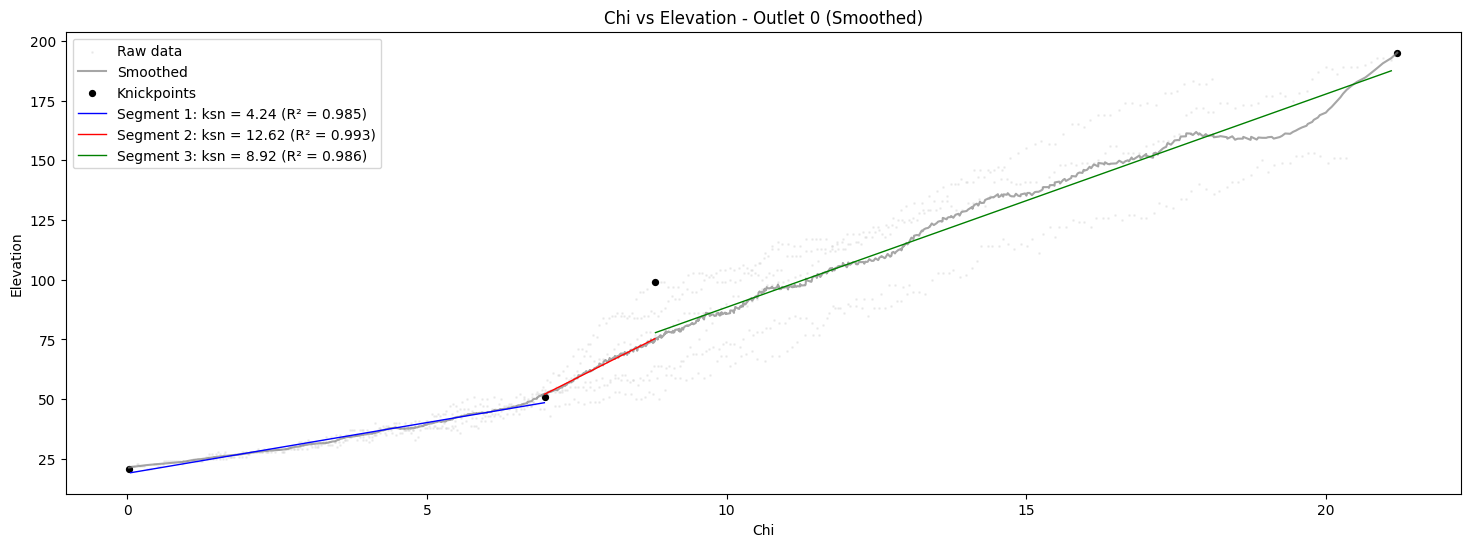

Outlet 0: ksn values = ['4.24', '12.62', '8.92']


[4.2434931725283205, 12.615938281342771, 8.923878881201093]

In [15]:
# RP-S2
analyze_outlet_smoothed(0, [(0.026572082, 21), (6.96, 51), (8.81, 99), (21.1904427, 195)], smooth=True, window=51)

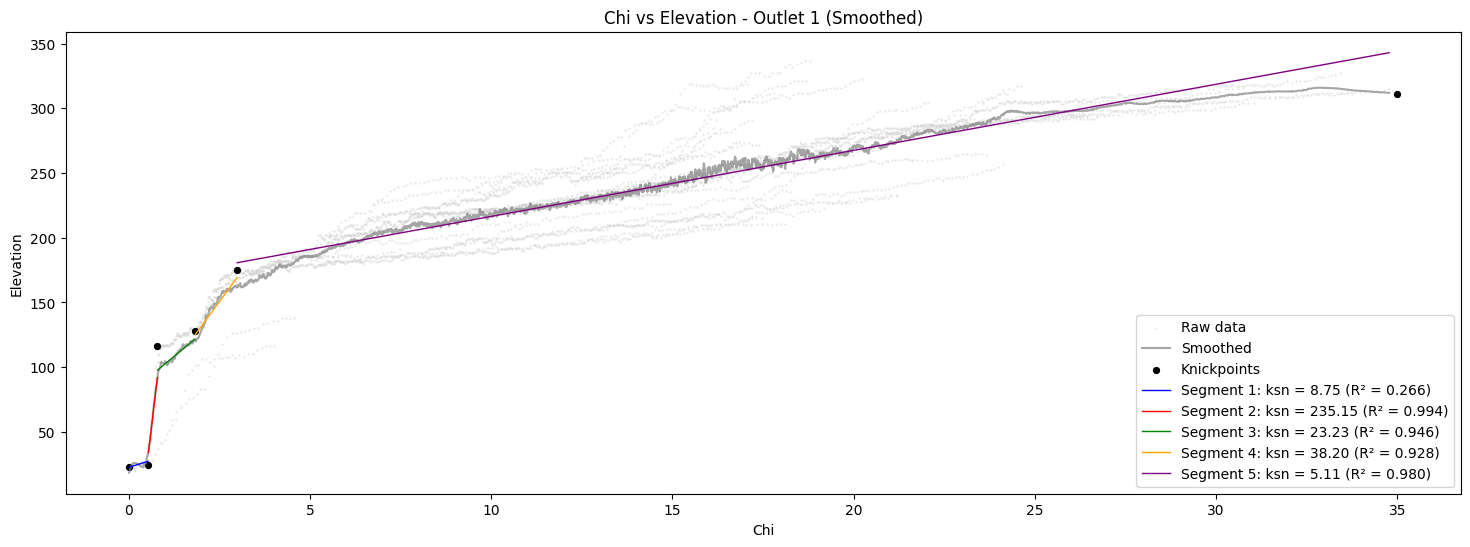

Outlet 1: ksn values = ['8.75', '235.15', '23.23', '38.20', '5.11']


[8.75072323881374,
 235.15211349704117,
 23.228909177420547,
 38.200613579243004,
 5.108126417976834]

In [16]:
# Rapel River outlets - modify knickpoints and run individual analyses
# RP-S3
analyze_outlet_smoothed(1, [(0.012829789, 23), (0.547, 24), (0.796, 116), (1.84, 128), (2.997, 175), (35, 311)], smooth=True, window=51)

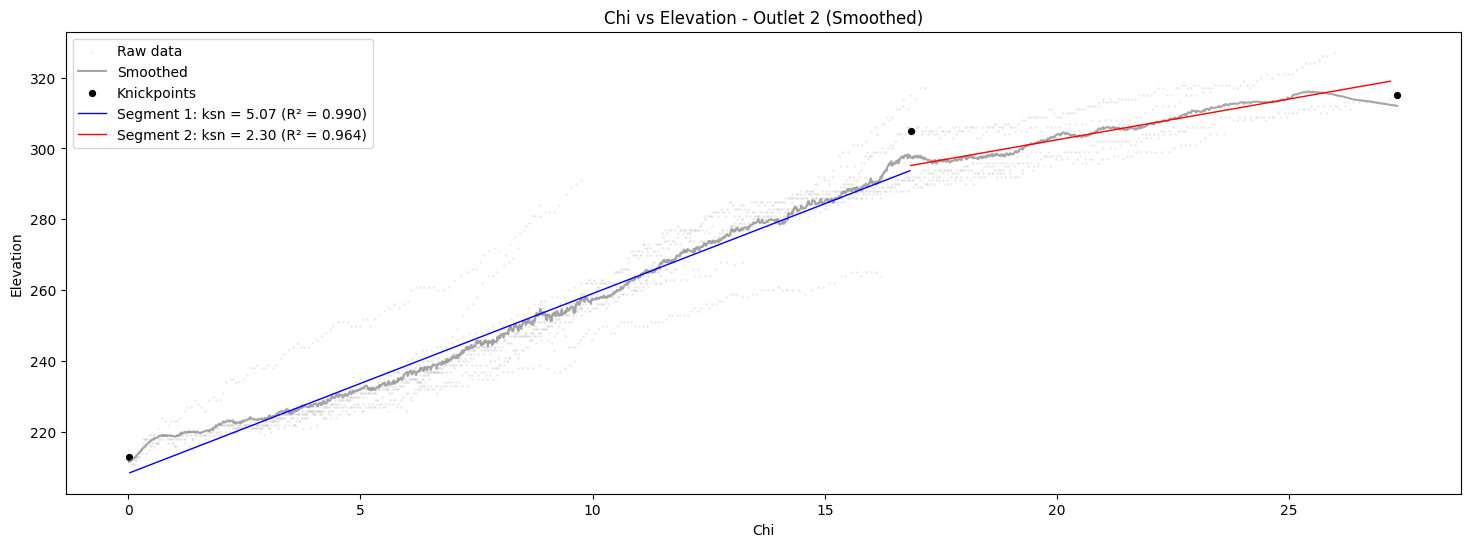

Outlet 2: ksn values = ['5.07', '2.30']


[5.0715740229507835, 2.3028767507250274]

In [17]:
# RP-S3u
analyze_outlet_smoothed(2, [(0.016482489, 213), (16.85, 305), (27.32708722,315)], smooth=True, window=51)

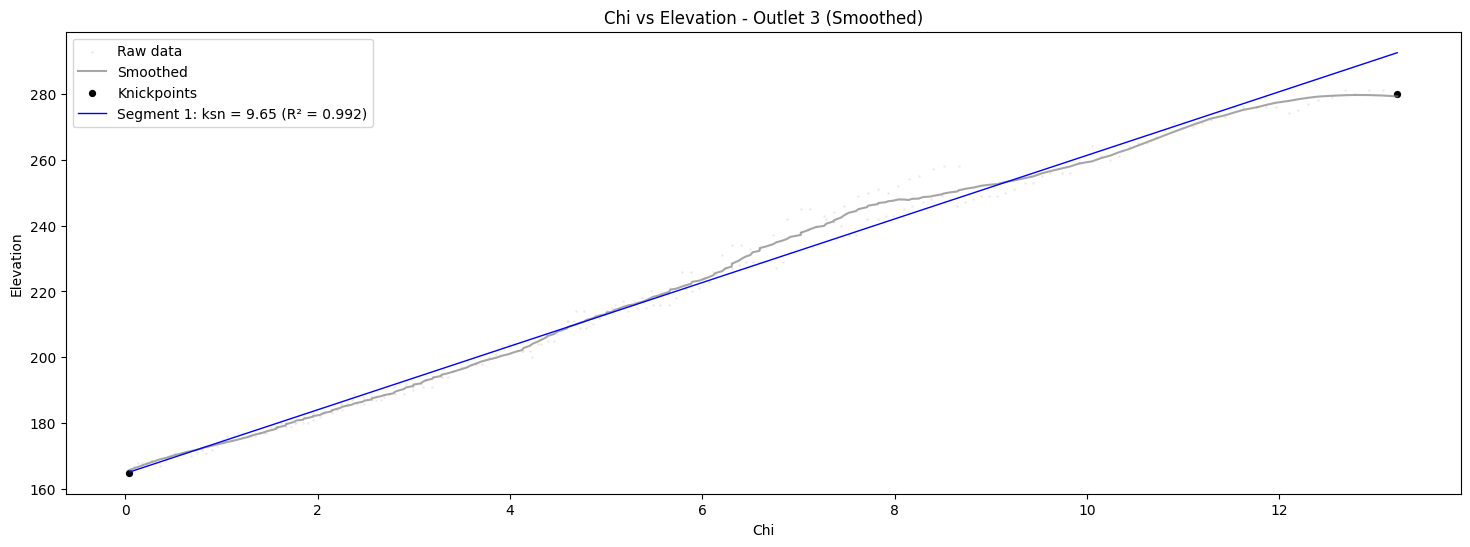

Outlet 3: ksn values = ['9.65']


[9.648144540379505]

In [18]:
# RP-S4u
analyze_outlet_smoothed(3, [(0.04, 165), (13.23, 280)], smooth=True, window=51)

In [19]:
# Read shapefiles
shp1 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp')
shp2 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp')
shp3 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3u_mask/RP_S3u_mask.shp')
shp4 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S4u_mask/RP_S4u_mask.shp')

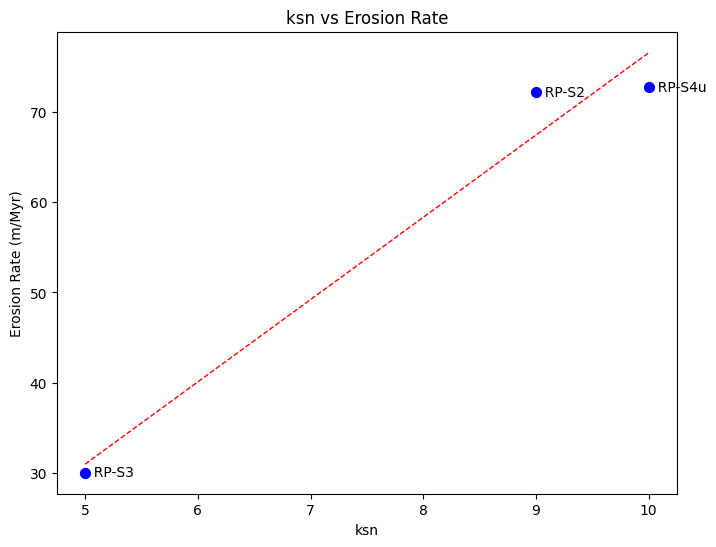

Slope: 9.129
R-squared: 0.969
P-value: 0.113


In [7]:
# Plotting ksn vs erosion

import matplotlib.pyplot as plt

# Your data
samples = ['RP-S2', 'RP-S3', 'RP-S4u']
ksn_values = [9, 5, 10]  # approximate values you mentioned
erosion_rates = [72.2, 30, 72.8]  # You need to fill these in

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(ksn_values, erosion_rates)

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(ksn_values, erosion_rates, s=50, color='blue')

# Label each point
for i, sample in enumerate(samples):
    plt.text(ksn_values[i], erosion_rates[i], f'  {sample}', 
             fontsize=10, verticalalignment='center')

# Plot the regression line
x_line = np.linspace(min(ksn_values), max(ksn_values), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r--', linewidth=1, 
         label=f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.3f}')

plt.xlabel('ksn')
plt.ylabel('Erosion Rate (m/Myr)')
plt.title('ksn vs Erosion Rate')
plt.show()

print(f"Slope: {slope:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value:.3f}")

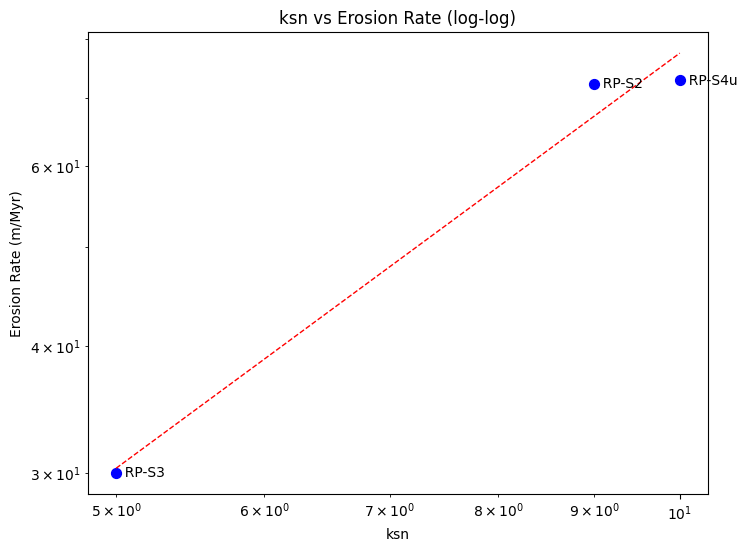


Log-log fit:
Power law exponent (n): 1.352
R-squared: 0.982
P-value: 0.085


In [6]:
# Additional log-log plot
plt.figure(figsize=(8, 6))
plt.scatter(ksn_values, erosion_rates, s=50, color='blue')

# Label each point
for i, sample in enumerate(samples):
    plt.text(ksn_values[i], erosion_rates[i], f'  {sample}', 
             fontsize=10, verticalalignment='center')

# For log-log, do regression on log-transformed data
log_ksn = np.linspace(np.log10(min(ksn_values)), np.log10(max(ksn_values)), 100)
log_slope, log_intercept, log_r_value, log_p_value, log_std_err = linregress(np.log10(ksn_values), np.log10(erosion_rates))

# Plot regression line (convert back from log space)
x_line_log = 10**log_ksn
y_line_log = 10**(log_slope * log_ksn + log_intercept)
plt.plot(x_line_log, y_line_log, 'r--', linewidth=1, 
         label=f'n = {log_slope:.2f}\nR² = {log_r_value**2:.3f}')

# Set both axes to log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('ksn')
plt.ylabel('Erosion Rate (m/Myr)')
plt.title('ksn vs Erosion Rate (log-log)')
plt.show()

print(f"\nLog-log fit:")
print(f"Power law exponent (n): {log_slope:.3f}")
print(f"R-squared: {log_r_value**2:.3f}")
print(f"P-value: {log_p_value:.3f}")

# Plotting adjacent tributaries and rivers as a comparison of knickpoint locations
117m and 175m plotted as red lines for reference

In [22]:
# Plotting chi vs elevation def

def plot_chi_elevation(outlet, sample_name):
    """
    Plot chi vs elevation for a single outlet and save data to CSV.
    
    outlet: the outlet point to analyze
    sample_name: name for the plot title (like 'RP-S2')
    """
    # Calculate chi
    chi_single = d.Chi(flow_direction=fd, area=area, theta=0.45, Ao=1, outlets=[outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6  # 1 km^2 in m^2
    
    # Create DataFrame with the filtered data
    df = pd.DataFrame({
        'id': sample_name,
        'chi_m': chi_data[mask_out],
        'elevation_m': elev_data[mask_out],
        'area_m2': area_data[mask_out]
    })
    
    # Save to CSV
    csv_filename = f'chi_elevation_{sample_name}.csv'
    df.to_csv(csv_filename, index=False)
    print(f'Saved data to {csv_filename}')
    
    # Make the plot
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_data[mask_out], elev_data[mask_out], s=1, alpha=0.5)
    plt.axhline(y=117, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=175, color='red', linestyle='--', linewidth=1)
    
    plt.xlabel('$\\chi$(m)')
    plt.ylabel('Elevation(m)')
    plt.title(f'$\\chi$ vs Elevation - {sample_name}')
    plt.show()

In [21]:
import pandas as pd
# Read the CSV file
tributaries = pd.read_csv('rapel_region_tributaries.csv')
# Plot for each tributary using id
for i, row in tributaries.iterrows():
    outlet = (row['x'], row['y'])
    plot_chi_elevation(outlet, row['id'])

ValueError: cannot convert float NaN to integer

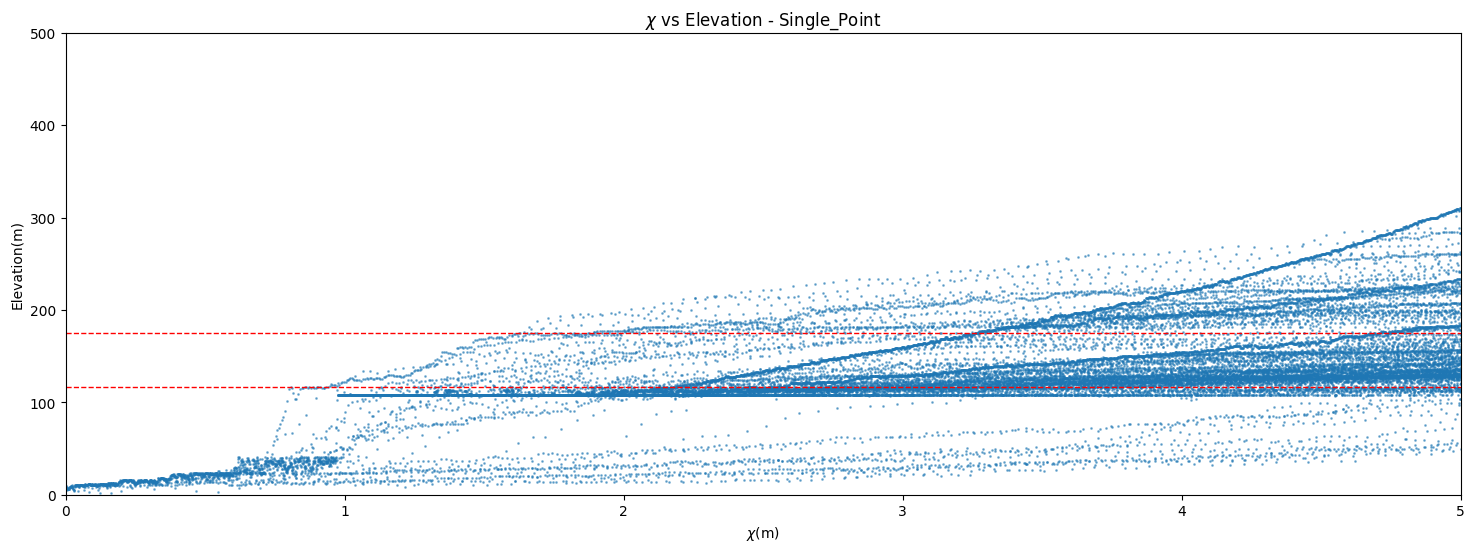

In [27]:
# Define your single outlet point
outlet = (240012.3742, 6244480.719)
sample_name = 'Single_Point'

# Calculate chi
chi_single = d.Chi(flow_direction=fd, area=area, theta=0.45, Ao=1, outlets=[outlet])

chi_data = chi_single._griddata[chi_single._griddata > 0]
elev_data = elevation._griddata[chi_single._griddata > 0]
area_data = area._griddata[chi_single._griddata > 0]

# Mask out areas less than 1 km^2
mask_out = area_data >= 1e6  # 1 km^2 in m^2

# Make the plot
plt.figure(figsize=(18, 6))
plt.scatter(chi_data[mask_out], elev_data[mask_out], s=1, alpha=0.5)
plt.axhline(y=117, color='red', linestyle='--', linewidth=1)
plt.axhline(y=175, color='red', linestyle='--', linewidth=1)

plt.xlim(0, 5)  # Set x-axis limit to 5
plt.ylim(0, 500)

plt.xlabel('$\\chi$(m)')
plt.ylabel('Elevation(m)')
plt.title(f'$\\chi$ vs Elevation - {sample_name}')
plt.show()

# Spatially averaged steepness

RP-S2: ksn = 8.58, R² = 0.915
RP-S3: ksn = 5.91, R² = 0.748
RP-S3u: ksn = 4.55, R² = 0.931
RP-S4u: ksn = 9.64, R² = 0.986

Correlation: R² = 0.843, p = 0.082


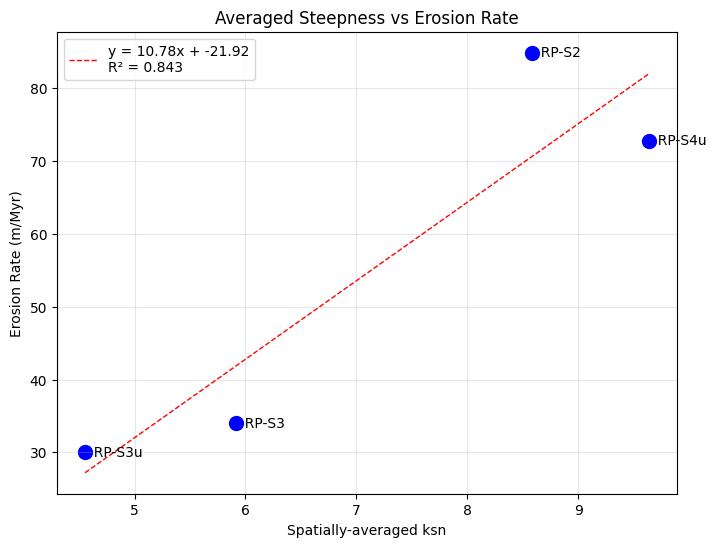

In [14]:
# Calculate spatially-averaged steepness for each sample
from scipy.stats import linregress

# Erosion rate data m/myr
erosion_data = {
    'RP-S2': 84.9,      
    'RP-S3': 34,     
    'RP-S3u': 30,     
    'RP-S4u': 72.8      
}

averaged_ksn = []
erosion_rates = []
sample_names = []

# Loop through each watershed
for i, (outlet, sample) in enumerate(zip(outlets, samples)):
    chi_single = d.Chi(flow_direction=fd, area=area, theta=0.4, Ao=1, outlets=[outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6
    
    # Calculate steepness (ksn) as slope of chi-elevation relationship
    slope, intercept, r_value, p_value, std_err = linregress(chi_data[mask_out], elev_data[mask_out])
    
    print(f"{sample}: ksn = {slope:.2f}, R² = {r_value**2:.3f}")
    
    # Store if erosion rate is available
    if erosion_data[sample] is not None:
        averaged_ksn.append(slope)
        erosion_rates.append(erosion_data[sample])
        sample_names.append(sample)

# Plot ksn vs erosion rate
plt.figure(figsize=(8, 6))
plt.scatter(averaged_ksn, erosion_rates, s=100, color='blue')

# Label points
for i, name in enumerate(sample_names):
    plt.text(averaged_ksn[i], erosion_rates[i], f'  {name}', 
             fontsize=10, verticalalignment='center')

# Linear regression
if len(averaged_ksn) >= 2:
    slope_corr, intercept_corr, r_corr, p_corr, std_err_corr = linregress(averaged_ksn, erosion_rates)
    
    x_line = np.linspace(min(averaged_ksn), max(averaged_ksn), 100)
    y_line = slope_corr * x_line + intercept_corr
    plt.plot(x_line, y_line, 'r--', linewidth=1, 
             label=f'y = {slope_corr:.2f}x + {intercept_corr:.2f}\nR² = {r_corr**2:.3f}')
    
    print(f"\nCorrelation: R² = {r_corr**2:.3f}, p = {p_corr:.3f}")

plt.xlabel('Spatially-averaged ksn')
plt.ylabel('Erosion Rate (m/Myr)')
plt.title('Averaged Steepness vs Erosion Rate')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

6: ksn = 5.82, R² = 0.939
7: ksn = 2.32, R² = 0.891
8: ksn = 8.53, R² = 0.964
9: ksn = 5.41, R² = 0.845
10: ksn = 10.92, R² = 0.875
11: ksn = 8.20, R² = 0.673
12: ksn = 7.02, R² = 0.950
13: ksn = 9.62, R² = 0.786
14: ksn = 12.95, R² = 0.916
15: ksn = 10.01, R² = 0.948
16: ksn = 20.15, R² = 0.918
17: ksn = 12.30, R² = 0.821
18: ksn = 9.54, R² = 0.905
19: ksn = 10.14, R² = 0.948
20: ksn = 8.24, R² = 0.983
21: ksn = 9.00, R² = 0.943
22: ksn = 6.64, R² = 0.622
23: ksn = 7.25, R² = 0.849


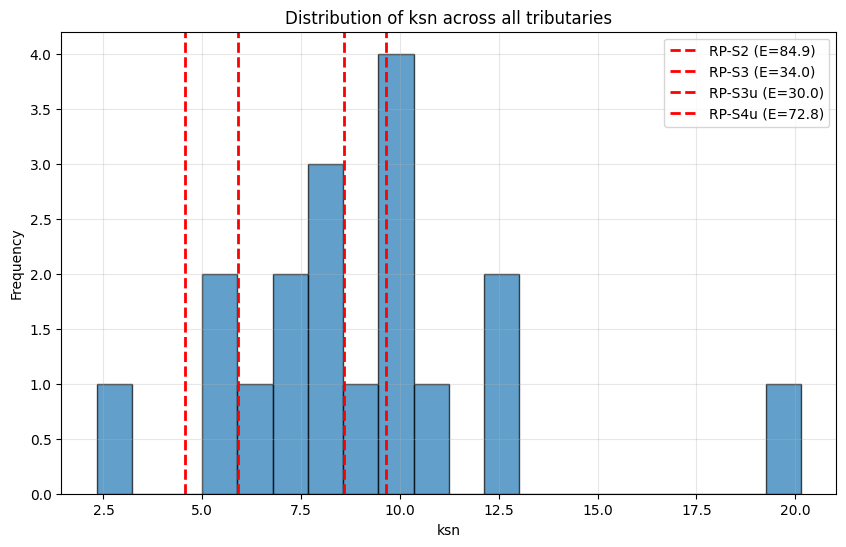


All tributaries: Mean ksn = 9.11, Std = 3.64


In [18]:
import pandas as pd

# Read the CSV file
tributaries = pd.read_csv('rapel_region_tributaries.csv')

# Store ksn values
tributary_ksn = []
tributary_ids = []

# Calculate ksn for each tributary
for i, row in tributaries.iterrows():
    outlet = (row['x'], row['y'])
    
    chi_single = d.Chi(flow_direction=fd, area=area, theta=0.4, Ao=1, outlets=[outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6
    
    # Only proceed if we have enough data
    if np.sum(mask_out) > 10:
        slope, intercept, r_value, p_value, std_err = linregress(chi_data[mask_out], elev_data[mask_out])
        
        tributary_ksn.append(slope)
        tributary_ids.append(row['id'])
        
        print(f"{row['id']}: ksn = {slope:.2f}, R² = {r_value**2:.3f}")

print(f"\nAll tributaries: Mean ksn = {np.mean(tributary_ksn):.2f}, Std = {np.std(tributary_ksn):.2f}")

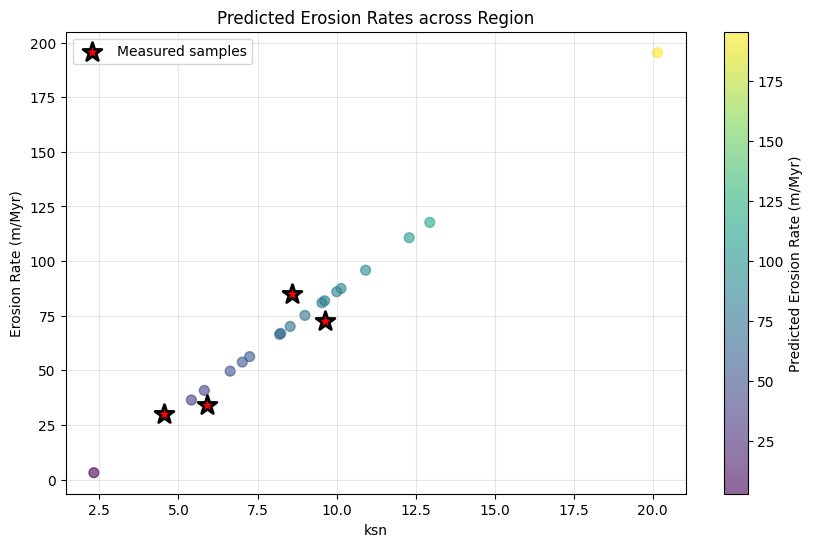

In [19]:
# Use your existing correlation to predict erosion rates
# (only if you're confident in the relationship!)

if len(averaged_ksn) >= 2:
    # Use the correlation from your sampled sites
    slope_corr, intercept_corr, r_corr, p_corr, std_err_corr = linregress(averaged_ksn, erosion_rates)
    
    # Predict erosion rates for all tributaries
    predicted_erosion = []
    
    for ksn in tributary_ksn:
        predicted_e = slope_corr * ksn + intercept_corr
        predicted_erosion.append(predicted_e)
    
    # Create a map-like plot showing predicted erosion rates
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tributary_ksn, predicted_erosion, c=predicted_erosion, 
                         cmap='viridis', s=50, alpha=0.6)
    plt.colorbar(scatter, label='Predicted Erosion Rate (m/Myr)')
    
    # Overlay your actual measurements
    plt.scatter(averaged_ksn, erosion_rates, s=200, color='red', 
               edgecolor='black', linewidth=2, marker='*', 
               label='Measured samples', zorder=5)
    
    plt.xlabel('ksn')
    plt.ylabel('Erosion Rate (m/Myr)')
    plt.title('Predicted Erosion Rates across Region')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

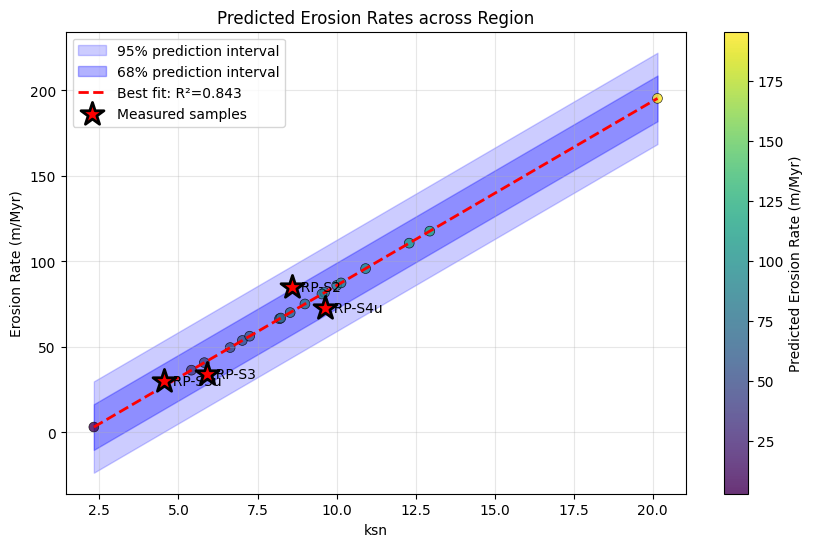

Prediction uncertainty (SE): ±13.4 m/Myr


In [22]:
# Use your existing correlation to predict erosion rates
if len(averaged_ksn) >= 2:
    slope_corr, intercept_corr, r_corr, p_corr, std_err_corr = linregress(averaged_ksn, erosion_rates)
    
    # Predict erosion rates for all tributaries
    predicted_erosion = []
    for ksn in tributary_ksn:
        predicted_e = slope_corr * ksn + intercept_corr
        predicted_erosion.append(predicted_e)
    
    # Calculate prediction uncertainty
    # Standard error of prediction
    residuals = np.array(erosion_rates) - (slope_corr * np.array(averaged_ksn) + intercept_corr)
    se = np.sqrt(np.sum(residuals**2) / (len(averaged_ksn) - 2))
    
    plt.figure(figsize=(10, 6))
    
    # Plot regression line with uncertainty band
    x_line = np.linspace(min(tributary_ksn), max(tributary_ksn), 100)
    y_line = slope_corr * x_line + intercept_corr
    
    # Add uncertainty bands (±1 and ±2 standard errors)
    plt.fill_between(x_line, y_line - 2*se, y_line + 2*se, alpha=0.2, color='blue', label='95% prediction interval')
    plt.fill_between(x_line, y_line - se, y_line + se, alpha=0.3, color='blue', label='68% prediction interval')
    
    # Plot all tributaries colored by predicted erosion
    scatter = plt.scatter(tributary_ksn, predicted_erosion, c=predicted_erosion, 
                         cmap='viridis', s=50, alpha=0.8, edgecolor='black', linewidth=0.5)
    plt.colorbar(scatter, label='Predicted Erosion Rate (m/Myr)')
    
    # Plot regression line
    plt.plot(x_line, y_line, 'r--', linewidth=2, label=f'Best fit: R²={r_corr**2:.3f}')
    
    # Overlay your actual measurements
    plt.scatter(averaged_ksn, erosion_rates, s=300, color='red', 
               edgecolor='black', linewidth=2, marker='*', 
               label='Measured samples', zorder=5)
    
    # Label measured samples
    for i, name in enumerate(sample_names):
        plt.text(averaged_ksn[i], erosion_rates[i], f'  {name}', 
                fontsize=10, verticalalignment='center')
    
    plt.xlabel('ksn')
    plt.ylabel('Erosion Rate (m/Myr)')
    plt.title('Predicted Erosion Rates across Region')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Prediction uncertainty (SE): ±{se:.1f} m/Myr")

# Hypsometric analysis

In [53]:
import numpy as np
import matplotlib.pyplot as plt


def calculate_hypsometric_curve(elevation_data, num_bins=100):
    """
    Calculate hypsometric curve following Strahler (1952) and Schumm (1956).
    
    The hypsometric curve is an area-altitude curve that defines the distribution 
    of elevation within a drainage basin.
    
    Parameters:
    -----------
    elevation_data : array
        2D array of elevation values (DEM)
    num_bins : int
        Number of elevation bins (default=100)
    
    Returns:
    --------
    x : array
        Relative area (a/A) - cumulative area from 0 to 1
    y : array
        Relative height (h/H) - normalized elevation from 0 to 1
    Hi : float
        Hypsometric integral
    
    Equations:
    ----------
    x = a/A (cumulative area / total area)
    y = h/H (height / total height)
    Hi = (E_mean - E_min) / (E_max - E_min)
    
    where:
    - a = surface area within the contour
    - A = total drainage basin area
    - h = height of the basin within the contour
    - H = total height of the basin
    """
    # Remove NaN values
    valid_elevations = elevation_data[~np.isnan(elevation_data)]
    
    # Get elevation statistics
    E_min = np.min(valid_elevations)
    E_max = np.max(valid_elevations)
    E_mean = np.mean(valid_elevations)
    
    # Calculate Hypsometric Integral (Eq. 2)
    Hi = (E_mean - E_min) / (E_max - E_min)
    
    # Create elevation bins
    bins = np.linspace(E_min, E_max, num_bins)
    
    # Count pixels in each elevation bin (represents area at each elevation)
    hist, bin_edges = np.histogram(valid_elevations, bins=bins)
    
    # Calculate cumulative area from TOP down (high elevation to low)
    # This makes the curve go from top-left to bottom-right as in the paper
    cumulative_area = np.cumsum(hist[::-1])[::-1]  # Reverse, cumsum, reverse back
    total_area = np.sum(hist)
    
    # Normalize to 0-1 range
    # x = a/A (cumulative area / total area)
    # Area at or ABOVE this elevation
    x = cumulative_area / total_area
    
    # y = h/H (normalized elevation)
    y = (bin_edges[1:] - E_min) / (E_max - E_min)
    
    return x, y, Hi


def plot_hypsometric_curve(elevation_data, title="Hypsometric Curve", num_bins=100):
    """
    Plot hypsometric curve with interpretation zones.
    
    Parameters:
    -----------
    elevation_data : array
        2D array of elevation values (DEM)
    title : str
        Plot title
    num_bins : int
        Number of elevation bins
    
    Returns:
    --------
    fig : matplotlib figure
    Hi : float
        Hypsometric integral value
    """
    # Calculate hypsometric curve
    x, y, Hi = calculate_hypsometric_curve(elevation_data, num_bins)
    
    # Get elevation statistics
    valid_elevations = elevation_data[~np.isnan(elevation_data)]
    E_min = np.min(valid_elevations)
    E_max = np.max(valid_elevations)
    E_mean = np.mean(valid_elevations)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the hypsometric curve
    ax.plot(x, y, 'b-', linewidth=2.5, label=f'Hi = {Hi:.3f}')
    
    # Add reference lines
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Labels and formatting
    ax.set_xlabel('Relative Area (a/A)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Relative Height (h/H)', fontsize=12, fontweight='bold')
    ax.set_title(f'{title}\nHypsometric Integral = {Hi:.3f}', 
                 fontsize=13, fontweight='bold')
    
    # Set axis limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # Add legend
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    
    # Add elevation statistics text box
    textstr = f'E_min = {E_min:.0f} m\nE_mean = {E_mean:.0f} m\nE_max = {E_max:.0f} m\nRelief = {E_max-E_min:.0f} m'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    return fig, Hi


def plot_multiple_hypsometric_curves(elevation_data_list, titles, num_bins=100):
    """
    Plot multiple hypsometric curves on one figure for comparison.
    
    Parameters:
    -----------
    elevation_data_list : list of arrays
        List of 2D elevation arrays (one per sub-watershed)
    titles : list of str
        List of names for each sub-watershed
    num_bins : int
        Number of elevation bins
    
    Returns:
    --------
    fig : matplotlib figure
    Hi_values : list
        List of hypsometric integral values for each watershed
    """
    n_watersheds = len(elevation_data_list)
    
    # Create subplot layout (2x2 for 4 watersheds)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    Hi_values = []
    
    for idx, (elev_data, title) in enumerate(zip(elevation_data_list, titles)):
        ax = axes[idx]
        
        # Calculate hypsometric curve
        x, y, Hi = calculate_hypsometric_curve(elev_data, num_bins)
        Hi_values.append(Hi)
        
        # Get elevation statistics
        valid_elevations = elev_data[~np.isnan(elev_data)]
        E_min = np.min(valid_elevations)
        E_max = np.max(valid_elevations)
        E_mean = np.mean(valid_elevations)
        
        # Plot the hypsometric curve
        ax.plot(x, y, 'b-', linewidth=2.5, label=f'Hi = {Hi:.3f}')
        
        # Add reference lines
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        
        # Labels and formatting
        ax.set_xlabel('Relative Area (a/A)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Relative Height (h/H)', fontsize=11, fontweight='bold')
        ax.set_title(f'{title}\nHi = {Hi:.3f}', fontsize=12, fontweight='bold')
        
        # Set axis limits
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        
        # Add legend (only for first plot to avoid clutter)
        if idx == 0:
            ax.legend(loc='best', fontsize=8, framealpha=0.9)
        
        # Add elevation statistics text box
        textstr = f'E_min = {E_min:.0f} m\nE_max = {E_max:.0f} m\nRelief = {E_max-E_min:.0f} m'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=props)
    
    plt.suptitle('Sub-Watershed Hypsometric Curves Comparison', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return fig, Hi_values


def plot_combined_hypsometric_curves(elevation_data_list, titles, num_bins=100):
    """
    Plot all hypsometric curves on a single plot for direct comparison.
    
    Parameters:
    -----------
    elevation_data_list : list of arrays
        List of 2D elevation arrays (one per sub-watershed)
    titles : list of str
        List of names for each sub-watershed
    num_bins : int
        Number of elevation bins
    
    Returns:
    --------
    fig : matplotlib figure
    Hi_values : list
        List of hypsometric integral values for each watershed
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Color palette for different watersheds
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    Hi_values = []
    
    for idx, (elev_data, title) in enumerate(zip(elevation_data_list, titles)):
        # Calculate hypsometric curve
        x, y, Hi = calculate_hypsometric_curve(elev_data, num_bins)
        Hi_values.append(Hi)
        
        # Plot the curve
        ax.plot(x, y, '-', linewidth=2.5, color=colors[idx % len(colors)],
                label=f'{title} (Hi = {Hi:.3f})')
    
    # Add reference lines
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Labels and formatting
    ax.set_xlabel('Relative Area (a/A)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Relative Height (h/H)', fontsize=12, fontweight='bold')
    ax.set_title('Sub-Watersheds Hypsometric Curves Comparison', 
                 fontsize=14, fontweight='bold')
    
    # Set axis limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # Add legend
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    
    plt.tight_layout()
    
    return fig, Hi_values


def extract_basin_elevation(fd, elevation, outlet_xy):
    """
    Extract elevation data for the basin draining to a specific outlet.
    
    Parameters:
    -----------
    fd : FlowDirectionD8 object
        Flow direction grid
    elevation : Elevation object
        Full DEM
    outlet_xy : tuple
        (x, y) coordinates of the outlet
    
    Returns:
    --------
    basin_elevation : array
        Elevation values within the basin (1D array with NaN removed)
    """
    # Get the basin bounds/mask for this outlet
    try:
        # Get all upstream cells for this outlet
        outlet_x, outlet_y = outlet_xy
        upstream_indices = fd.get_indexes_of_upstream_cells_for_location(outlet_x, outlet_y)
        
        # Create a mask for the basin
        elev_array = get_array_data(elevation)
        basin_mask = np.zeros(elev_array.shape, dtype=bool)
        
        # Mark all upstream cells as part of basin
        for idx in upstream_indices:
            if isinstance(idx, (tuple, list)):
                row, col = idx
            else:
                continue
            if 0 <= row < elev_array.shape[0] and 0 <= col < elev_array.shape[1]:
                basin_mask[row, col] = True
        
        # Also add the outlet cell
        row_col = fd._xy_to_rowscols([outlet_xy])
        outlet_row, outlet_col = row_col[0]
        basin_mask[outlet_row, outlet_col] = True
        
        # Extract elevation values within basin
        basin_elevation = elev_array[basin_mask]
        
        # Remove NaN values
        basin_elevation = basin_elevation[~np.isnan(basin_elevation)]
        
        return basin_elevation
        
    except Exception as e:
        print(f"Error extracting basin: {e}")
        print("Trying alternative method using bounds...")
        
        # Alternative: use bounds_of_basin_for_outlet
        try:
            bounds = fd.bounds_of_basin_for_outlet(outlet_xy)
            # bounds should give you the extent of the basin
            # Extract elevation within those bounds
            elev_array = get_array_data(elevation)
            
            # This is a simpler approach - just use a rectangular clip
            # You may need to adjust based on what bounds returns
            min_row, max_row, min_col, max_col = bounds
            basin_elevation = elev_array[min_row:max_row, min_col:max_col]
            basin_elevation = basin_elevation[~np.isnan(basin_elevation)].flatten()
            
            return basin_elevation
        except Exception as e2:
            print(f"Alternative method also failed: {e2}")
            return None


def plot_subwatershed_hypsometries(fd, elevation, outlets, sample_names, num_bins=100):
    """
    Extract basins for each outlet and plot their hypsometric curves.
    
    Parameters:
    -----------
    fd : FlowDirectionD8 object
        Flow direction grid
    elevation : Elevation object
        Full DEM
    outlets : list of tuples
        List of (x, y) outlet coordinates
    sample_names : list of str
        Names for each sub-watershed
    num_bins : int
        Number of elevation bins
    
    Returns:
    --------
    fig : matplotlib figure
    Hi_values : list
        Hypsometric integral for each watershed
    """
    n_watersheds = len(outlets)
    
    # Create subplot layout
    if n_watersheds == 4:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(1, n_watersheds, figsize=(5*n_watersheds, 5))
        if n_watersheds == 1:
            axes = [axes]
    
    Hi_values = []
    
    print("Extracting basins and calculating hypsometric curves...")
    print("="*60)
    
    for idx, (outlet, name) in enumerate(zip(outlets, sample_names)):
        print(f"\n{name}:")
        ax = axes[idx]
        
        # Extract basin elevation
        basin_elev = extract_basin_elevation(fd, elevation, outlet)
        
        if basin_elev is None or len(basin_elev) < 100:
            print(f"  WARNING: Could not extract basin or too few pixels")
            ax.text(0.5, 0.5, 'Basin extraction failed', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(name)
            continue
        
        print(f"  Basin pixels: {len(basin_elev)}")
        print(f"  Elevation range: {basin_elev.min():.0f} to {basin_elev.max():.0f} m")
        
        # Calculate hypsometric curve
        x, y, Hi = calculate_hypsometric_curve(basin_elev, num_bins)
        Hi_values.append(Hi)
        
        E_min = np.min(basin_elev)
        E_max = np.max(basin_elev)
        E_mean = np.mean(basin_elev)
        
        print(f"  Hypsometric Integral: {Hi:.3f}")
        
        # Plot the hypsometric curve
        ax.plot(x, y, 'b-', linewidth=2.5, label=f'Hi = {Hi:.3f}')
        
        # Add reference lines
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        
        # Labels and formatting
        ax.set_xlabel('Relative Area (a/A)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Relative Height (h/H)', fontsize=11, fontweight='bold')
        ax.set_title(f'{name}\nHi = {Hi:.3f}', fontsize=12, fontweight='bold')
        
        # Set axis limits
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        
        # Add elevation statistics text box
        textstr = f'E_min = {E_min:.0f} m\nE_max = {E_max:.0f} m\nRelief = {E_max-E_min:.0f} m'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=props)
    
    plt.suptitle('Sub-Watershed Hypsometric Curves', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    print("\n" + "="*60)
    print("Summary:")
    for name, Hi in zip(sample_names, Hi_values):
        print(f"  {name}: Hi = {Hi:.3f}")
    
    return fig, Hi_values


# Example usage
print("Hypsometric Curve Functions Loaded!")

Hypsometric Curve Functions Loaded!


Extracting basins and calculating hypsometric curves...

RP-S2:
  Basin pixels: 45438
  Elevation range: 20 to 306 m
  Hypsometric Integral: 0.482

RP-S3:
  Basin pixels: 280501
  Elevation range: 20 to 409 m
  Hypsometric Integral: 0.645

RP-S3u:
  Basin pixels: 149943
  Elevation range: 206 to 402 m
  Hypsometric Integral: 0.448

RP-S4u:
  Basin pixels: 12499
  Elevation range: 165 to 329 m
  Hypsometric Integral: 0.612

Summary:
  RP-S2: Hi = 0.482
  RP-S3: Hi = 0.645
  RP-S3u: Hi = 0.448
  RP-S4u: Hi = 0.612


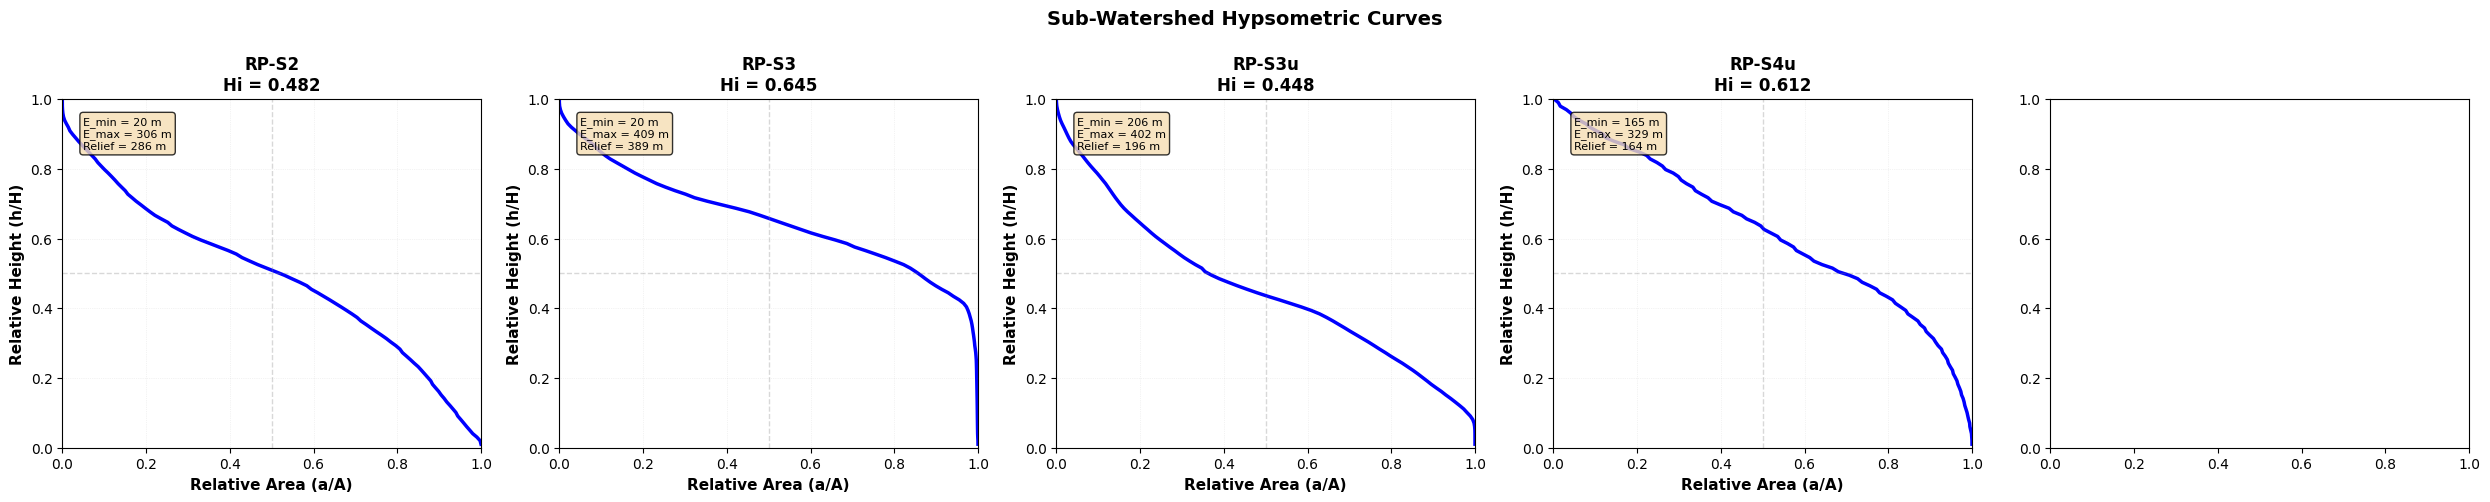

In [54]:
# Plot hypsometric curves for all 4 sub-watersheds
fig, Hi_values = plot_subwatershed_hypsometries(
    fd, elevation, outlets, samples
)
plt.show()